0    False,True,True,True,True,True,True,True,True,...
1    True,True,True,True,False,False,True,True,True...
2    False,False,False,False,False,False,False,True...
3    False,False,False,True,True,False,True,True,Tr...
4    False,False,False,True,True,True,True,True,Tru...
Name: match, dtype: object


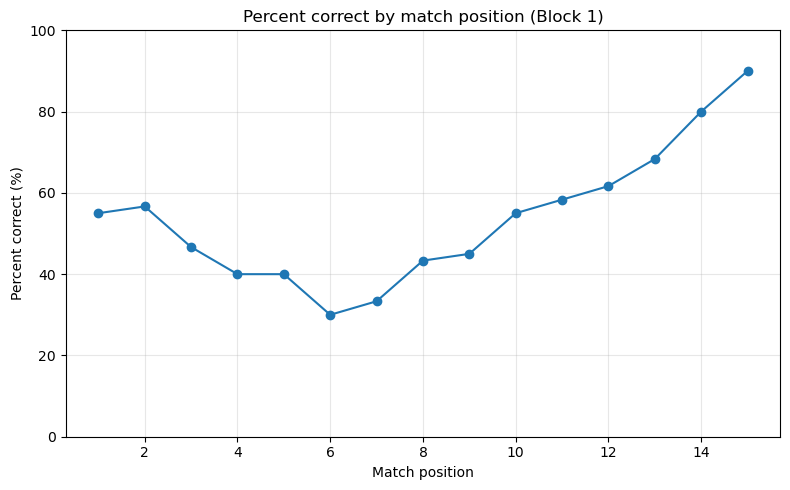

In [55]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("free_recall_results_block_2.csv")

df["match_list"] = df["match"].apply(lambda x: [m.strip() == "True" for m in x.split(",")])



print(df["match"].head())

match_expanded = pd.DataFrame(df["match_list"].tolist())

# --- Percent correct for each match position across all trials ---
percent_by_position = match_expanded.mean(axis=0) * 100
percent_by_position.index = percent_by_position.index + 1  # position labels 1..15


plt.figure(figsize=(8,5))
plt.plot(percent_by_position.index, percent_by_position.values, marker="o")
plt.ylim(0, 100)
plt.xlabel("Match position")
plt.ylabel("Percent correct (%)")
plt.title("Percent correct by match position (Block 1)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [38]:
import scipy.stats as st
import numpy as np

files = [
    "free_recall_results_block_1.csv",
    "free_recall_results_block_2.csv",
    "free_recall_results_block_3.csv",
    "free_recall_results_block_4.csv",
    "free_recall_results_block_5.csv"
]

for file in files:
    df = pd.read_csv(file)
    pct_correct = df["score"]/df["total"]
    mean = np.mean(pct_correct)
    se   = st.sem(pct_correct)  # standard error of the mean
    ci95 = st.t.interval(0.95, len(pct_correct)-1, loc=mean, scale=se)
    print(f"{file} - Mean: {mean:.3f}, 95% CI: ({ci95[0]:.3f}, {ci95[1]:.3f})")

free_recall_results_block_1.csv - Mean: 0.441, 95% CI: (0.409, 0.473)
free_recall_results_block_2.csv - Mean: 0.536, 95% CI: (0.496, 0.576)
free_recall_results_block_3.csv - Mean: 0.480, 95% CI: (0.452, 0.508)
free_recall_results_block_4.csv - Mean: 0.417, 95% CI: (0.358, 0.476)
free_recall_results_block_5.csv - Mean: 0.434, 95% CI: (0.400, 0.469)


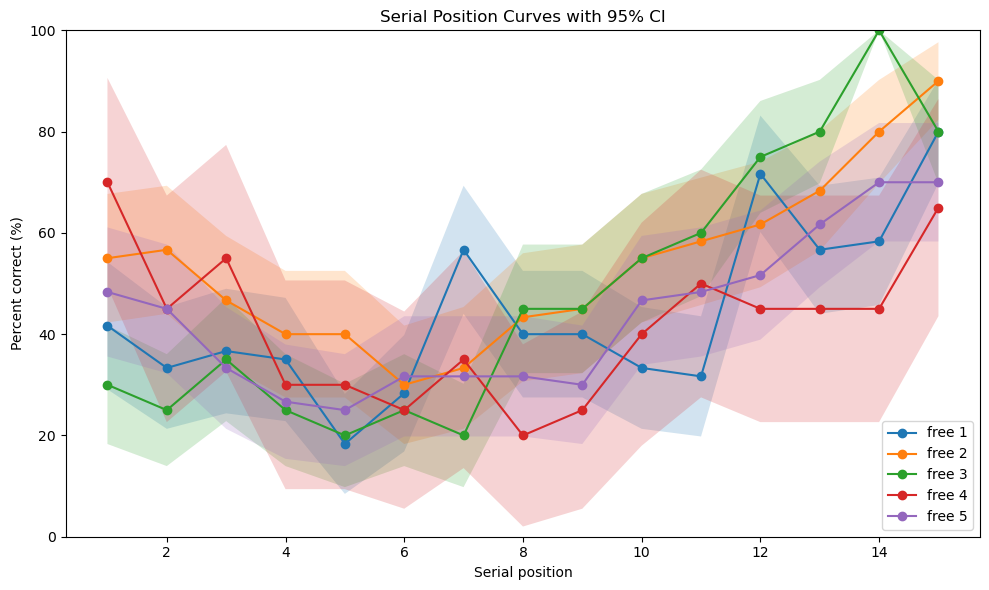

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW

# --- List of CSV files (replace with your filenames) ---
files = [
    "free_recall_results_block_1.csv",
    "free_recall_results_block_2.csv",
    "free_recall_results_block_3.csv",
    "free_recall_results_block_4.csv",
    "free_recall_results_block_5.csv"
]
exp_labels = ["free 1","free 2","free 3","free 4","free 5"]

all_data = []

for fname, label in zip(files, exp_labels):
    df = pd.read_csv(fname)
    # Parse match into list of booleans
    df["match_list"] = df["match"].apply(lambda s: [m.strip() == "True" for m in str(s).split(",")])
    
    # Expand into (trial × position) rows
    expanded = pd.DataFrame(df["match_list"].tolist())
    expanded["trial"] = np.arange(len(expanded)) + 1
    long = expanded.melt(id_vars="trial", var_name="position", value_name="correct")
    long["position"] = long["position"] + 1  # 1..N
    long["experiment"] = label
    all_data.append(long)

# Combine across experiments
long_df = pd.concat(all_data, ignore_index=True)

# --- Compute mean + 95% CI for each experiment × position ---
summary = []
for (exp, pos), group in long_df.groupby(["experiment","position"]):
    d = group["correct"].astype(int).values
    mean = np.mean(d) * 100
    se = np.std(d, ddof=1)/np.sqrt(len(d)) * 100
    # 95% CI (normal approx)
    ci_low, ci_high = mean - 1.96*se, mean + 1.96*se
    summary.append({"experiment":exp,"position":pos,"mean":mean,"ci_low":ci_low,"ci_high":ci_high})

summary_df = pd.DataFrame(summary)

# --- Plot serial position curves with CI ---
plt.figure(figsize=(10,6))

for exp in exp_labels:
    sub = summary_df[summary_df["experiment"]==exp]
    plt.plot(sub["position"], sub["mean"], marker="o", label=exp)
    plt.fill_between(sub["position"], sub["ci_low"], sub["ci_high"], alpha=0.2)

plt.ylim(0,100)
plt.xlabel("Serial position")
plt.ylabel("Percent correct (%)")
plt.title("Serial Position Curves with 95% CI")
plt.legend()
plt.tight_layout()
plt.show()


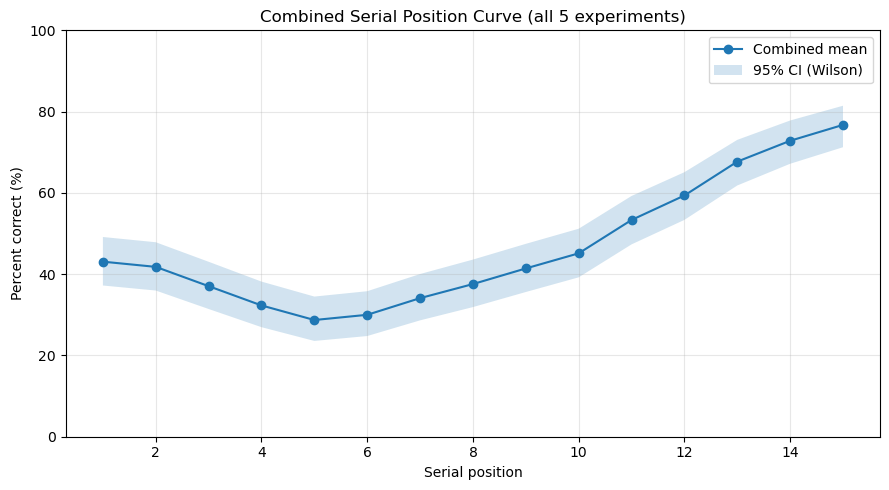

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- 1) List your files here ----
files = [
    "free_recall_results_block_1.csv",
    "free_recall_results_block_2.csv",
    "free_recall_results_block_3.csv",
    "free_recall_results_block_4.csv",
    "free_recall_results_block_5.csv"
]


# ---- 2) Helpers ----
def parse_match(s):
    # "True,False,..." -> [True, False, ...]
    return [t.strip() == "True" for t in str(s).split(",")]

def wilson_ci(k, n, alpha=0.05):
    """
    Wilson score interval for a binomial proportion.
    Returns (lower, upper) in proportion units (0..1).
    """
    if n == 0:
        return (0.0, 0.0)
    from math import sqrt
    z = 1.959963984540054  # ~95% two-sided
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    half = z * np.sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    return max(0.0, center - half), min(1.0, center + half)

# ---- 3) Load & expand all experiments into long format ----
long_rows = []
for fname in files:
    df = pd.read_csv(fname)
    match_lists = df["match"].apply(parse_match)
    # Expand: each row -> 15 columns -> melt to long: (trial, position, correct)
    M = pd.DataFrame(match_lists.tolist())            # shape: trials x positions
    M["trial"] = np.arange(1, len(M)+1)
    long = M.melt(id_vars="trial", var_name="position", value_name="correct")
    long["position"] = long["position"] + 1           # 1..15
    long_rows.append(long[["position", "correct"]])

all_long = pd.concat(long_rows, ignore_index=True)
all_long["correct"] = all_long["correct"].astype(bool)

# ---- 4) Pool across all experiments: successes, totals, pct, CI ----
agg = all_long.groupby("position")["correct"].agg(
    successes="sum", total="count"
).reset_index()

agg["prop"] = agg["successes"] / agg["total"]
ci = agg.apply(lambda r: wilson_ci(r["successes"], r["total"]), axis=1)
agg["ci_low"]  = [c[0] for c in ci]
agg["ci_high"] = [c[1] for c in ci]

# Convert to percent for plotting
agg["pct"]      = 100 * agg["prop"]
agg["ci_low_p"] = 100 * agg["ci_low"]
agg["ci_high_p"]= 100 * agg["ci_high"]

# Optional: light smoothing of the curve (comment out if you don’t want it)
window = 3
agg["pct_smooth"] = agg["pct"].rolling(window, center=True, min_periods=1).mean()
agg["low_smooth"] = agg["ci_low_p"].rolling(window, center=True, min_periods=1).mean()
agg["high_smooth"]= agg["ci_high_p"].rolling(window, center=True, min_periods=1).mean()

# ---- 5) Plot single combined SPC + CI ----
plt.figure(figsize=(9,5))
x = agg["position"]
plt.plot(x, agg["pct_smooth"], marker="o", label="Combined mean")
plt.fill_between(x, agg["low_smooth"], agg["high_smooth"], alpha=0.2, label="95% CI (Wilson)")
plt.ylim(0, 100)
plt.xlabel("Serial position")
plt.ylabel("Percent correct (%)")
plt.title("Combined Serial Position Curve (all 5 experiments)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# If you want the raw (unsmoothed) curve, change to:
# plt.plot(x, agg["pct"], marker="o", label="Combined mean")
# plt.fill_between(x, agg["ci_low_p"], agg["ci_high_p"], alpha=0.2, label="95% CI (Wilson)")


# Serial recall 

In [61]:
import scipy.stats as st
import numpy as np

files = [
    "serial_recall_block_1.csv",
    "serial_recall_block_2.csv",
    "serial_recall_block_3_fingertap.csv",
    "serial_recall_block_4_lalalal.csv"
]

for file in files:
    df = pd.read_csv(file)
    pct_correct = df["score"]/df["total"]
    mean = np.mean(pct_correct)
    se   = st.sem(pct_correct)  # standard error of the mean
    ci95 = st.t.interval(0.95, len(pct_correct)-1, loc=mean, scale=se)
    print(f"{file} - Mean: {mean:.3f}, 95% CI: ({ci95[0]:.3f}, {ci95[1]:.3f})")

serial_recall_block_1.csv - Mean: 0.282, 95% CI: (0.243, 0.321)
serial_recall_block_2.csv - Mean: 0.338, 95% CI: (0.296, 0.379)
serial_recall_block_3_fingertap.csv - Mean: 0.325, 95% CI: (0.276, 0.374)
serial_recall_block_4_lalalal.csv - Mean: 0.270, 95% CI: (0.235, 0.305)
